In [31]:
import itertools
import os

import numpy as np
import pandas as pd

# column descriptions from https://www.retrosheet.org/gamelogs/glfields.txt
offensive_stats = ['AB', 'H', '2B', '3B', 'HR', 'RBI', 'SAC', 'SAC_FLY', 'HBP', 'BB', 'IBB', 'K', 'SB', 'CS', 'GDP', 'CI', 'LOB']
pitching_stats = ['pitchers_used', 'indv_earned_runs', 'team_earned_runs', 'wild_pitches', 'balks']
defensive_stats = ['putouts', 'assists', 'errors', 'passed_balls', 'double_plays', 'triple_plays']
roles = ['home_plate_ump', '1B_ump', '2B_ump', '3B_ump', 'LF_ump', 'RF_ump', 'away_manager', 'home_manager',
         'winning_pitcher', 'losing_pitcher', 'saving_pitcher', 'winning_rbi_batter', 'away_starting_pitcher', 'home_starting_pitcher']
columns = [
    'date',
    'series_game_num',
    'dow',
    'away_team',
    'away_team_league',
    'away_team_game_num',
    'home_team',
    'home_team_league',
    'home_team_game_num',
    'score_away',
    'score_home',
    'count_outs',
    'day_or_night',
    'makeup_info',
    'forfeit_info',
    'protest_info',
    'park_id',
    'attendance',
    'length_minutes',
    'away_line_score',
    'home_line_score',
    *['away_' + offensive_stat for offensive_stat in offensive_stats],
    *['away_' + pitching_stat for pitching_stat in pitching_stats],
    *['away_' + defensive_stat for defensive_stat in defensive_stats],
    *['home_' + offensive_stat for offensive_stat in offensive_stats],
    *['home_' + pitching_stat for pitching_stat in pitching_stats],
    *['home_' + defensive_stat for defensive_stat in defensive_stats],
    *list(itertools.chain.from_iterable([[role + '_id', role + '_name'] for role in roles])),
    *list(itertools.chain.from_iterable([[f'away_lineup{i}_id', f'away_lineup{i}_name', f'away_lineup{i}_pos'] for i in range(1, 10)])),
    *list(itertools.chain.from_iterable([[f'home_lineup{i}_id', f'home_lineup{i}_name', f'home_lineup{i}_pos'] for i in range(1, 10)])),
    'misc',
    'acquisition_info'
]

def file_to_df(fn):
    df = pd.read_csv(fn, header=None, names=columns)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df['year'] = df['date'].dt.year
    df['home_won'] = df['score_home'] > df['score_away']
    return df

def opposite_side(side):
    return 'home' if side == 'away' else 'away'

dfs = []
for fn in os.listdir('data'):
    year_df = file_to_df(f'data/{fn}')
    dfs.append(year_df)
    
df = pd.concat(dfs).sort_values(['date', 'home_team_game_num'])

In [178]:
df2010 = df[df['year'] == 2010]

side_games_dfs = []
for side in ['home', 'away']:
    side_games = df2010.copy()
    side_games['won'] = df2010['home_won'] if side == 'home' else ~df2010['home_won']
    side_games['team'] = df2010[f'{side}_team']
    side_games['game_num'] = df2010[f'{side}_team_game_num'] + 1 # win pct = pct before game_num, to avoid lookahead bias
    side_games['score_for'] = df2010[f'score_{side}']
    side_games['score_against'] = df2010[f'score_{opposite_side(side)}']
    side_games_dfs.append(side_games)
    
team_games = pd.concat(side_games_dfs).sort_values(['team', 'game_num'])

tmp = team_games.pivot(columns='team', values='won', index='game_num').cumsum()
team_wins = tmp.divide(tmp.index.values, axis='rows').unstack().rename('win_pct')
team_avg_score_for = team_games.pivot(columns='team', values='score_for', index='game_num').expanding().mean().unstack().rename('avg_score_for')
team_avg_score_against = team_games.pivot(columns='team', values='score_against', index='game_num').expanding().mean().unstack().rename('avg_score_against')
team_stats = pd.concat([team_wins, team_avg_score_for, team_avg_score_against], axis='columns').reset_index()

In [228]:
tmp = pd.merge(
    df2010[['date', 'home_team', 'away_team', 'home_team_game_num', 'away_team_game_num', 'home_won']],
    team_stats.rename(columns={col: 'home_team' if col == 'team' else f'home_team_{col}' for col in team_stats.columns}),
    on=['home_team', 'home_team_game_num']
)
games = pd.merge(
    tmp,
    team_stats.rename(columns={col: 'away_team' if col == 'team' else f'away_team_{col}' for col in team_stats.columns}),
    on=['away_team', 'away_team_game_num']
)

games['pred_score_home'] = np.sqrt(games['home_team_avg_score_for'] * games['away_team_avg_score_against'])
games['pred_score_away'] = np.sqrt(games['away_team_avg_score_for'] * games['home_team_avg_score_against'])
games['pred_score_diff'] = games['pred_score_home'] - games['pred_score_away']
games['pred_score_diff_std'] = np.sqrt(games['home_team_avg_score_for'].var() + games['away_team_avg_score_for'].var())
games['home_win_prob1'] = (games['pred_score_diff'] / games['pred_score_diff_std']).apply(norm.cdf)
games['home_win_prob2'] = 0.558824 # % that home team wins
games['pred1_correct'] = (games['home_win_prob1'] > .5) == games['home_won']
games['pred2_correct'] = ((games['home_win_prob1'] + games['home_win_prob2']) / 2 > .5) == games['home_won']

<AxesSubplot:>

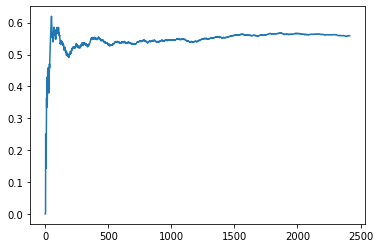

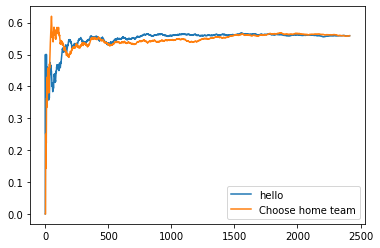

In [246]:
(games['home_won'].cumsum() / games.index.values).plot(label='hello')
(games['pred2_correct'].cumsum() / games.index.values).plot(label='Choose home team')
import matplotlib.pyplot as plt
plt.legend()